In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# generate fake data

In [2]:
# 390*60=60 days worth
n_data = 390 * 60

market_time = np.zeros((n_data,1))
stock_price = np.zeros((n_data,1))
stock_high = np.zeros((n_data,1))
stock_low = np.zeros((n_data,1))
stock_volume = np.zeros((n_data,1))

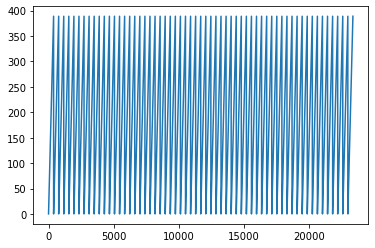

In [3]:
# market_time is in minutes, from 9:30 to 4pm, 390 minues
market_time[:,0] = np.mod(np.arange(n_data), 390)
plt.plot(market_time)

(0.0, 1000.0)

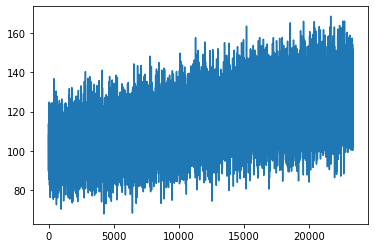

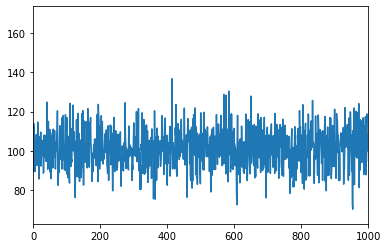

In [4]:
stock_price[:,0] = np.random.normal(100, 10, size=(n_data)) * (1 + np.arange(n_data)/n_data*0.3)
plt.plot(stock_price)
plt.figure()
plt.plot(stock_price)
plt.xlim(0,1000)

(0.0, 30.0)

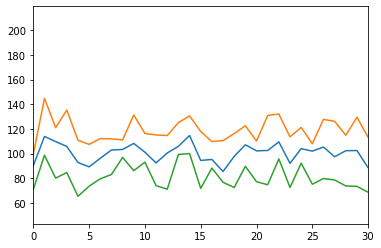

In [5]:
stock_high[:,0] = stock_price[:,0] * np.random.uniform(1.05, 1.3, size=(n_data))
stock_low[:,0] = stock_price[:,0] * np.random.uniform(0.95, 0.7, size=(n_data))
plt.plot(stock_price)
plt.plot(stock_high)
plt.plot(stock_low)
plt.xlim(0,30)

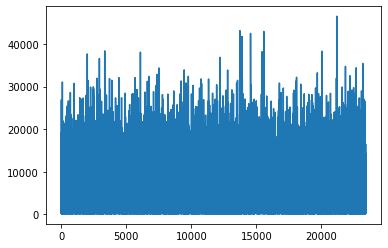

In [6]:
stock_volume[:,0] = np.maximum(np.random.normal(1000, 10000, size=(n_data)),0) + np.random.uniform(100, 1000, size=(n_data))
plt.plot(stock_volume)

# labeling data

In [7]:
# label as two numbers, first being buy, second being sell, -1 means error, 0 means no, 1 means yes
# exp: (0,1) means the price goes down in the future, so sell
# exp: (1,0) means the price goes up in the future, so buy
# exp: (0,0) means the price is stable in the future
# exp: (1,1) means the price fluctuates in the future

# look at the future prices between +future_1 minute and + future_2 minute, 
# if there are future price > current price * (1+thresh), than label it as buy
# if there are future price < current price * (1-thresh), than label it has sell

thresh = 0.25
future_1 = 10
future_2 = 100

stock_labels = np.ones((n_data,2)) * -1

for i in range (n_data-future_2):
    if np.max(stock_price[i+future_1:i+future_2],0) > stock_price[i,0]*(1+thresh):
        stock_labels[i,0] = 1
    else:
        stock_labels[i,0] = 0
        
    if np.min(stock_price[i+future_1:i+future_2],0) < stock_price[i,0]*(1-thresh):
        stock_labels[i,1] = 1
    else:
        stock_labels[i,1] = 0

(11194.0, 11244.0)

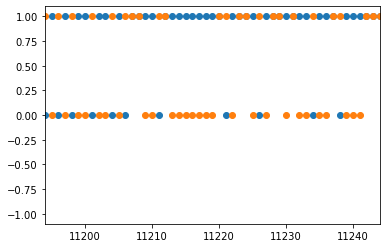

In [8]:
plt.plot(stock_labels[:,0],'o')
plt.plot(stock_labels[:,1],'o')
rand_range_start = np.random.randint(0,n_data-50)
plt.xlim(rand_range_start,rand_range_start+50)

# train and val data

In [9]:
# input: the previous 100 min of data
x_all = []
y_all = []
for i in range(100,n_data-future_2):
    x = np.concatenate((market_time[i-100:i], stock_price[i-100:i], stock_high[i-100:i], stock_low[i-100:i], stock_volume[i-100:i]), axis=1)
    x_all.append(x)
    y_all.append(stock_labels[i])
x_all = np.array(x_all)
y_all = np.array(y_all)

In [10]:
n_example = x_all.shape[0]
example_idxes = np.arange(n_example)
np.random.shuffle(example_idxes)
train_idxes = example_idxes[0:n_data*2//3]
val_idxes = example_idxes[n_data*2//3:]
print(x_all.shape, y_all.shape)
print(train_idxes.shape, val_idxes.shape)

(23200, 100, 5) (23200, 2)
(15600,) (7600,)


# simple ML model

In [11]:
import tensorflow as tf
import keras
from keras.models import Model, model_from_json
from keras.layers import Input, Flatten, Dense

from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [26]:
def buildModel(n_timepoint, n_features):
    a = Input(shape=(n_timepoint, n_features))
    
    b = Flatten()(a)
    b = Dense(128, activation='relu')(b)
    b = Dense(32, activation='relu')(b)

    c = Dense(2, activation='sigmoid')(b)
    model = Model(inputs=a, outputs=c)
    return model

In [27]:
model = buildModel(n_timepoint=100, n_features=5)
opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 5)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               64128     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 68,322
Trainable params: 68,322
Non-trainable params: 0
_________________________________________________________________


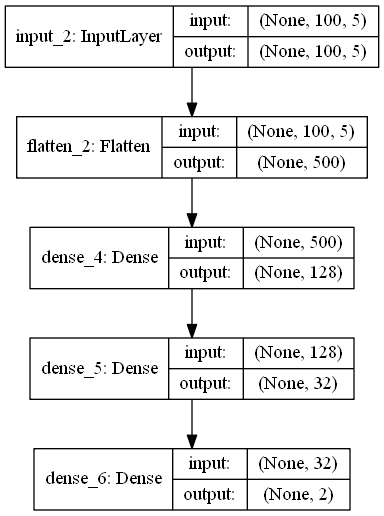

In [28]:
plot_model(model, show_shapes=True, show_layer_names=True)

# train model

In [29]:
history = model.fit(x=x_all[train_idxes], y=y_all[train_idxes], 
                    batch_size=1024, epochs=100, verbose=2, 
                    validation_data=(x_all[val_idxes], y_all[val_idxes]))

Train on 15600 samples, validate on 7600 samples
Epoch 1/100
 - 0s - loss: 552.0050 - accuracy: 0.5003 - val_loss: 254.6056 - val_accuracy: 0.4988
Epoch 2/100
 - 0s - loss: 151.6194 - accuracy: 0.5024 - val_loss: 41.7990 - val_accuracy: 0.5070
Epoch 3/100
 - 0s - loss: 11.1078 - accuracy: 0.5169 - val_loss: 1.1411 - val_accuracy: 0.5222
Epoch 4/100
 - 0s - loss: 0.8241 - accuracy: 0.5208 - val_loss: 0.7683 - val_accuracy: 0.5232
Epoch 5/100
 - 0s - loss: 0.7181 - accuracy: 0.5211 - val_loss: 0.7436 - val_accuracy: 0.5232
Epoch 6/100
 - 0s - loss: 0.7018 - accuracy: 0.5211 - val_loss: 0.7385 - val_accuracy: 0.5232
Epoch 7/100
 - 0s - loss: 0.6981 - accuracy: 0.5211 - val_loss: 0.7368 - val_accuracy: 0.5234
Epoch 8/100
 - 0s - loss: 0.6966 - accuracy: 0.5211 - val_loss: 0.7362 - val_accuracy: 0.5234
Epoch 9/100
 - 0s - loss: 0.6958 - accuracy: 0.5211 - val_loss: 0.7353 - val_accuracy: 0.5234
Epoch 10/100
 - 0s - loss: 0.6947 - accuracy: 0.5211 - val_loss: 0.7347 - val_accuracy: 0.5234
Ep

Epoch 87/100
 - 0s - loss: 0.6921 - accuracy: 0.5211 - val_loss: 0.7310 - val_accuracy: 0.5234
Epoch 88/100
 - 0s - loss: 0.6921 - accuracy: 0.5211 - val_loss: 0.7310 - val_accuracy: 0.5234
Epoch 89/100
 - 0s - loss: 0.6921 - accuracy: 0.5211 - val_loss: 0.7310 - val_accuracy: 0.5234
Epoch 90/100
 - 0s - loss: 0.6921 - accuracy: 0.5211 - val_loss: 0.7310 - val_accuracy: 0.5234
Epoch 91/100
 - 0s - loss: 0.6921 - accuracy: 0.5211 - val_loss: 0.7310 - val_accuracy: 0.5234
Epoch 92/100
 - 0s - loss: 0.6921 - accuracy: 0.5211 - val_loss: 0.7310 - val_accuracy: 0.5234
Epoch 93/100
 - 0s - loss: 0.6921 - accuracy: 0.5211 - val_loss: 0.7310 - val_accuracy: 0.5234
Epoch 94/100
 - 0s - loss: 0.6921 - accuracy: 0.5211 - val_loss: 0.7310 - val_accuracy: 0.5234
Epoch 95/100
 - 0s - loss: 0.6921 - accuracy: 0.5211 - val_loss: 0.7310 - val_accuracy: 0.5234
Epoch 96/100
 - 0s - loss: 0.6921 - accuracy: 0.5211 - val_loss: 0.7310 - val_accuracy: 0.5234
Epoch 97/100
 - 0s - loss: 0.6921 - accuracy: 0.52

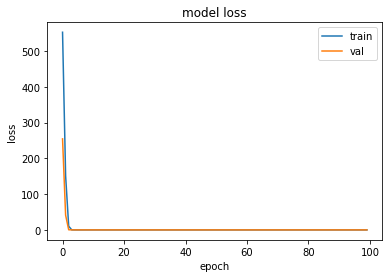

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

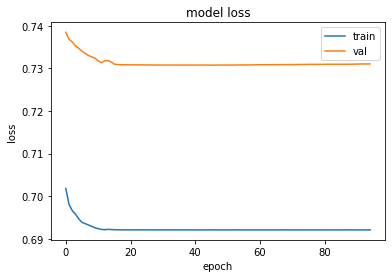

In [31]:
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

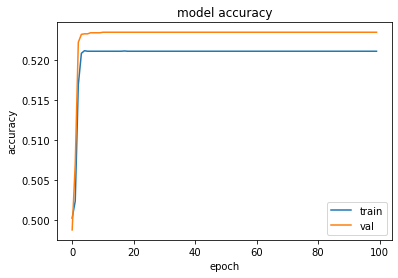

In [32]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# simulate on same data

In [20]:
init_stock_position = 0
init_cash = 10000

In [21]:
# strategy 1: buy all at time 0, sell all at the end
stock_position = init_cash / stock_price[0,0]
end_stock_value = stock_price[-future_2,0] * stock_position

print('Percent return:', end_stock_value / init_cash * 100 - 100)

Percent return: 59.425958553265104


In [22]:
# strategy 2: buy half, and then randomly buy and sell
percent_returns = []
for t in range(20):
    stock_position = init_cash / stock_price[0,0] / 2
    cash = init_cash / 2
    for i in range(n_data-future_2):
        action = np.random.randint(0,3)
        if action == 1:
            # buy one if you can
            if stock_price[i,0] < cash:
                stock_position += 1
                cash -= stock_price[i,0]
    #             print('bought 1 at', stock_price[i,0])
        elif action == 2:
            # sell one if you can
            if stock_position > 0:
                stock_position -= 1
                cash += stock_price[i,0]
    #             print('sold 1 at', stock_price[i,0])

    end_stock_value = stock_price[-future_2,0] * stock_position + cash
    print('Percent return:', end_stock_value / init_cash * 100 - 100)
    percent_returns.append(end_stock_value / init_cash * 100 - 100)
print('Average percent return:', np.average(percent_returns))

Percent return: 13.500564530092788
Percent return: 24.98848784909076
Percent return: -5.273188812775274
Percent return: 7.415212874331672
Percent return: 11.5965844944037
Percent return: 44.58260908853296
Percent return: 24.77788980851392
Percent return: 44.75155074917902
Percent return: 31.753496076221154
Percent return: 16.201851488371915
Percent return: 35.41698653930169
Percent return: 71.98013592315593
Percent return: 21.28048562978762
Percent return: 48.3446177517329
Percent return: 45.86562773713371
Percent return: 16.12800092990429
Percent return: 13.254697675455503
Percent return: 67.27983953656567
Percent return: 6.807934556957562
Percent return: 23.093053688216997
Average percent return: 28.18732190570872


In [23]:
# strategy 3: using the model, buy/sell as much as you can
stock_position = init_cash / stock_price[0,0] / 2
cash = init_cash / 2

actions = model.predict(x_all)

for i in range(100,n_data-future_2):
    if actions[i-100,0] > 0.5 and actions[i-100,1] < 0.5 and cash > 0:
        # buy as much as you can
        print('bought', cash / stock_price[i,0], 'at', stock_price[i,0])
        stock_position += cash / stock_price[i,0]
        cash = 0
    elif actions[i-100,0] < 0.5 and actions[i-100,1] > 0.5 and stock_position > 0:
        # sell as much as you can
        print('sold', stock_position, 'at', stock_price[i,0])
        cash += stock_price[i,0] * stock_position
        stock_position = 0

end_stock_value = stock_price[future_2,0] * stock_position + cash
print('Percent return:', end_stock_value / init_cash * 100 - 100)
percent_returns.append(end_stock_value / init_cash * 100 - 100)

sold 55.42396379367128 at 101.09029616220029
bought 84.1511079264226 at 125.99744882332222
sold 84.1511079264226 at 124.88250286634121
bought 90.78506521201372 at 115.75693592646765
Percent return: 6.181217432626141


In [24]:
# strategy 4: using the model, buy/sell 1
stock_position = init_cash / stock_price[0,0] / 2
cash = init_cash / 2

actions = model.predict(x_all)

for i in range(100,n_data-future_2):
    if actions[i-100,0] > 0.5 and actions[i-100,1] < 0.5 and cash > stock_price[i,0]:
        # buy 1
        print('bought 1 at', stock_price[i,0])  
        stock_position += 1
        cash -= stock_price[i,0]
    elif actions[i-100,0] < 0.5 and actions[i-100,1] > 0.5 and stock_position > 1:
        # sell 1
        print('sold 1 at', stock_price[i,0])
        stock_position -= 1
        cash += stock_price[i,0]

end_stock_value = stock_price[future_2,0] * stock_position + cash
print('Percent return:', end_stock_value / init_cash * 100 - 100)
percent_returns.append(end_stock_value / init_cash * 100 - 100)

sold 1 at 101.09029616220029
sold 1 at 84.56131380132285
sold 1 at 97.20871743038843
sold 1 at 124.57143895688432
sold 1 at 113.6683851541924
sold 1 at 112.10029494050475
sold 1 at 109.85241212951209
sold 1 at 118.74347583407412
sold 1 at 105.1972773323281
sold 1 at 123.38560221064661
sold 1 at 116.85731597248542
sold 1 at 127.02204829462063
sold 1 at 131.42278456644664
sold 1 at 127.6189987582512
sold 1 at 109.92497554435437
sold 1 at 131.54129597161102
sold 1 at 106.25518632745269
sold 1 at 133.70695751933783
sold 1 at 124.48107006705887
bought 1 at 125.99744882332222
sold 1 at 124.88250286634121
sold 1 at 130.08246177196042
sold 1 at 109.72087598718689
bought 1 at 115.75693592646765
Percent return: 14.652892899298948


# simulate on new data

In [25]:
# todo